In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


In [15]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [16]:
# load opsim database
#dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
#resultsDb = db.ResultsDb(outDir=outDir)



In [21]:
#df_baseline = pd.DataFrame( dataRaw )
#df_baseline = pd.read_pickle(outDir+'/tgaps_dataRaw_baseline_v1.5_10yrs.db.pkl')
df_baseline = pd.read_pickle(outDir+'/tgaps_baseline_v1.5_10yrs.db.pkl')

df_baseline.loc['baseline_v1.5_10yrs.db']['uu'].head()

,pixId,Dkl,FoM_i,Nv,dT_lim
0,1376,9.215521,0.022682,228,"[2543.0299859689258, 2517.1657840843764, 25.86..."
1,1377,8.892487,0.020750,151,"[325.06176144188794, 2897.0894808574594, 3222...."
2,1378,8.835138,0.015281,105,"[1061.1107692982987, 1388.0824860240027, 2449...."
3,1379,9.081613,0.021610,190,"[681.1237290293211, 348.9774169290613, 332.146..."
4,1380,8.617415,0.018997,105,"[2155.1549509010947, 2155.2038098323683, 0.048..."


In [22]:
tmin = 5/60/60/24 # in days
tmax = 3e8/60./60./24    
# histogram in log space
bins_log=np.logspace(np.log10(tmin), np.log10(tmax), 50)
            
tmin = 5/60/60/24
tmax = 1.5/24 # 1.5 hour in days
bins_lin = np.linspace(tmin, tmax, 50)




In [23]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return np.sum( prob_uni * np.log(prob_uni / prob) )
    
    else:
        return np.NaN

def get_FoM_tgaps(df, tmin=0, tmax=1.5/24, bins=50):
    """return FoM from array of metricValues
    Inputs:
     df: pd.DataFrame, cols ['pixId', 'Dkl', 'FoM_i', 'Nv', 'dT_lim']
    """
    
    dT_all = np.concatenate(df.dT_lim.values)
    
    dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
    Nv = len(dT_tlim)

    values, bins_ = np.histogram(dT_tlim, bins=bins);

    Dkl = get_Dkl(values)

    FoM = Nv * np.exp(-Dkl)
    
    return FoM




In [24]:
# prepare filter_dict
fltpairs = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy',
           'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy' ]

filter_dict = {}
for fltpair in fltpairs:
    filter_dict[fltpair] = {}
    dT = np.concatenate( df_baseline[fltpair]['baseline_v1.5_10yrs.db'] ['dT_lim'].values )
    filter_dict[fltpair]['dT'] = dT
    
    if fltpair[0]==fltpair[1]:
        bins = bins_log
        values, bins_ = np.histogram(dT, bins=bins);
    else:
        bins = bins_lin
        values, bins_ = np.histogram(dT, bins=bins);

    Dkl = get_Dkl(values)
    
    filter_dict[fltpair]['Dkl'] = Dkl
    print(fltpair, len(dT),  Dkl)
    

uu 2468080 5.398810362201651
ug 70578 2.1134440233740857
ur 66368 1.375961964396934
ui 9339 0.5016790761842163
uz 0 nan
uy 50 6.081792190269123
gg 5330741 5.312331831053857
gr 127608 1.6617405390844637
gi 24946 1.171693868930305
gz 987 0.43786301783702203
gy 494 0.61516906181712
rr 29186938 5.787795755226195
ri 180466 1.727938366489182
rz 14403 0.9063908925784445
ry 2043 0.40171911859405973
ii 29609453 6.215477775914526
iz 206627 1.8262000625825658
iy 38139 0.7669018018944066
zz 23694537 6.00344538601065
zy 174632 1.3822756018255706
yy 26094240 5.950768567363721


Text(0, 0.5, 'Nv (M)')

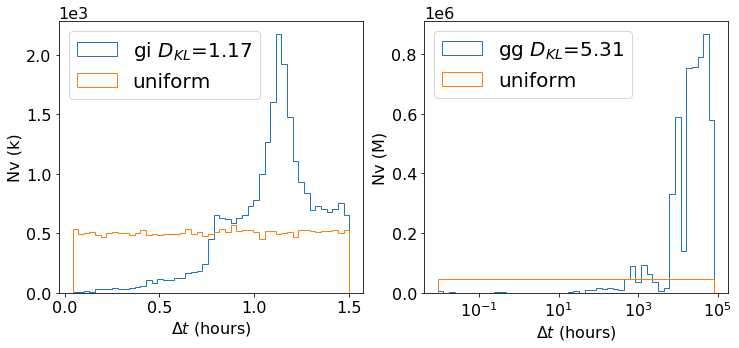

In [25]:
# plot a distribution with uniform one 

key = 'gi'
dT = filter_dict[key]['dT'] * 24
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

dkltex = '$D_{KL}$'
title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])

uni = np.random.uniform(low=dT.min(), high=dT.max(), size=len(dT) )

bins_lin = np.linspace(dT.min(), dT.max(), 50)

ax = axs[0]
_ = ax.hist(dT, bins=bins_lin, label=title, 
                          cumulative=False, density=False, histtype='step' );
_ = ax.hist(uni, bins=bins_lin, label='uniform', alpha=1,
                          cumulative=False, density=False, histtype='step'  );
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta t$ (hours)')
ax.set_ylabel('Nv (k)')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0,0), )

# --------------------------
key = 'gg'
dT = filter_dict[key]['dT'] * 24

low = np.log(dT.min())
high = np.log(dT.max())
uni = np.power(10, np.random.uniform(low=low, high=high, size=len(dT) ) )

title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])


tmin = dT.min()
tmax = dT.max()
bins_log=np.logspace(np.log10(tmin), np.log10(tmax), 50)

ax = axs[1]
_ = ax.hist(dT, bins=bins_log, label=title, 
                          cumulative=False, density=False, histtype='step' );

_ = ax.hist(uni, bins=bins_log, label='uniform', alpha=1,
                          cumulative=False, density=False, histtype='step'  );
ax.set_xscale('log')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0), )
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta t$ (hours)')
ax.set_ylabel('Nv (M)')

# fig.suptitle(title)

In [26]:
def plot_hist_colorbar(filter_dict, figsize=(20, 20), histbins=[50, 50], vmax=10000, **kwargs):
    """plot histogram
    Inputs:
        filter_dict: ['uu']['dT']
        
    """
    #fig, axs = plt.subplots(6, 6, figsize=figsize, constrained_layout=True); # 6 axes on a 2x3 grid
    fig, axs = plt.subplots(6, 6, figsize=figsize, constrained_layout=True);
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    cmap = matplotlib.cm.OrRd
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            dT = filter_dict[key] ['dT']
            #eDkl = filter_dict[key] ['eDkl']
            
            #title = '{}{} Nv={} $D_k$={:.2f}'.format(f0, f1, len(dT), filter_dict[key] ['Dkl'])                   
            dkltex = '$D_{KL}$'
            title = '{} {}={:.2f}'.format(key, dkltex, filter_dict[key] ['Dkl'])

            if f0==f1:
                vmin1 = 100000
                vmax1 = 30000000
                norm = matplotlib.colors.Normalize(vmin=vmin1, vmax=vmax1)
                m1 = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
                
                ax = axs[fdict[f0], 5]
                axs[fdict[f0], fdict[f1]].axis('off')
                # plot distribution
                Nv = len(dT)
                if Nv!=0:
                    values, bins, _ = ax.hist(dT*24, bins=histbins[0], color=m1.to_rgba(Nv), label=title, **kwargs );
                    ax.legend(loc='upper center', handlelength=0, handletextpad=0, frameon=False)
                ax.set_xscale("log")
                
            else:
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                
                vmin2 = 0
                vmax2 = 200000
                norm = matplotlib.colors.Normalize(vmin=vmin2, vmax=vmax2)
                m2 = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

                # plot distribution
                Nv = len(dT)
                #if Nv!=0:
                values, bins, _ = ax.hist(dT*24, bins=histbins[1], color=m2.to_rgba(Nv), label=title, **kwargs );
                ax.legend(loc='upper center', handlelength=0, handletextpad=0, frameon=False)
            
            # ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

            # ax.set_title(title)
            
            if fdict[f1]!=5:
                ax.get_xaxis().set_ticklabels([])
                
            ax.get_yaxis().set_ticks([])
            #ax.set_ylabel('N fields')
            print(key, Nv)
    for i in range(6):
        #axs[i, i].axis('off')
        axs[i, 5].axis('on')    
        axs[5, i].set_xlabel('$\Delta t$ (hours)')
          
    # cbar diagonal
    m1.set_array(np.linspace(vmin1, vmax1) ) 
    cbar1 = fig.colorbar(mappable=m1, ax=axs[:,5], shrink=1, location='bottom')
    cbar1.set_label('Nv')
    #cbar1.formatter.set_powerlimits((0, 0))
    #cbar1.update_ticks()

    # for off diagonal
    m2.set_array(np.linspace(vmin2, vmax2) ) 
    cbar2 = fig.colorbar(mappable=m2, ax=axs[:,:5], shrink=.6, location='bottom')
    cbar2.set_label('Nv')
    cbar2.set_clim([0, vmax2])

    cbar2.formatter.set_powerlimits((0, 0))
    cbar2.update_ticks()
    
    #fig.suptitle(dbfile, fontsize=16)
    #fig.savefig('{}.png'.format(filename), dpi=200)
    #fig.tight_layout( pad=1.0 )




uu 2468080
ug 70578
ur 66368
ui 9339
uz 0
uy 50
gg 5330741
gr 127608
gi 24946
gz 987
gy 494
rr 29186938
ri 180466
rz 14403
ry 2043
ii 29609453
iz 206627
iy 38139
zz 23694537
zy 174632
yy 26094240


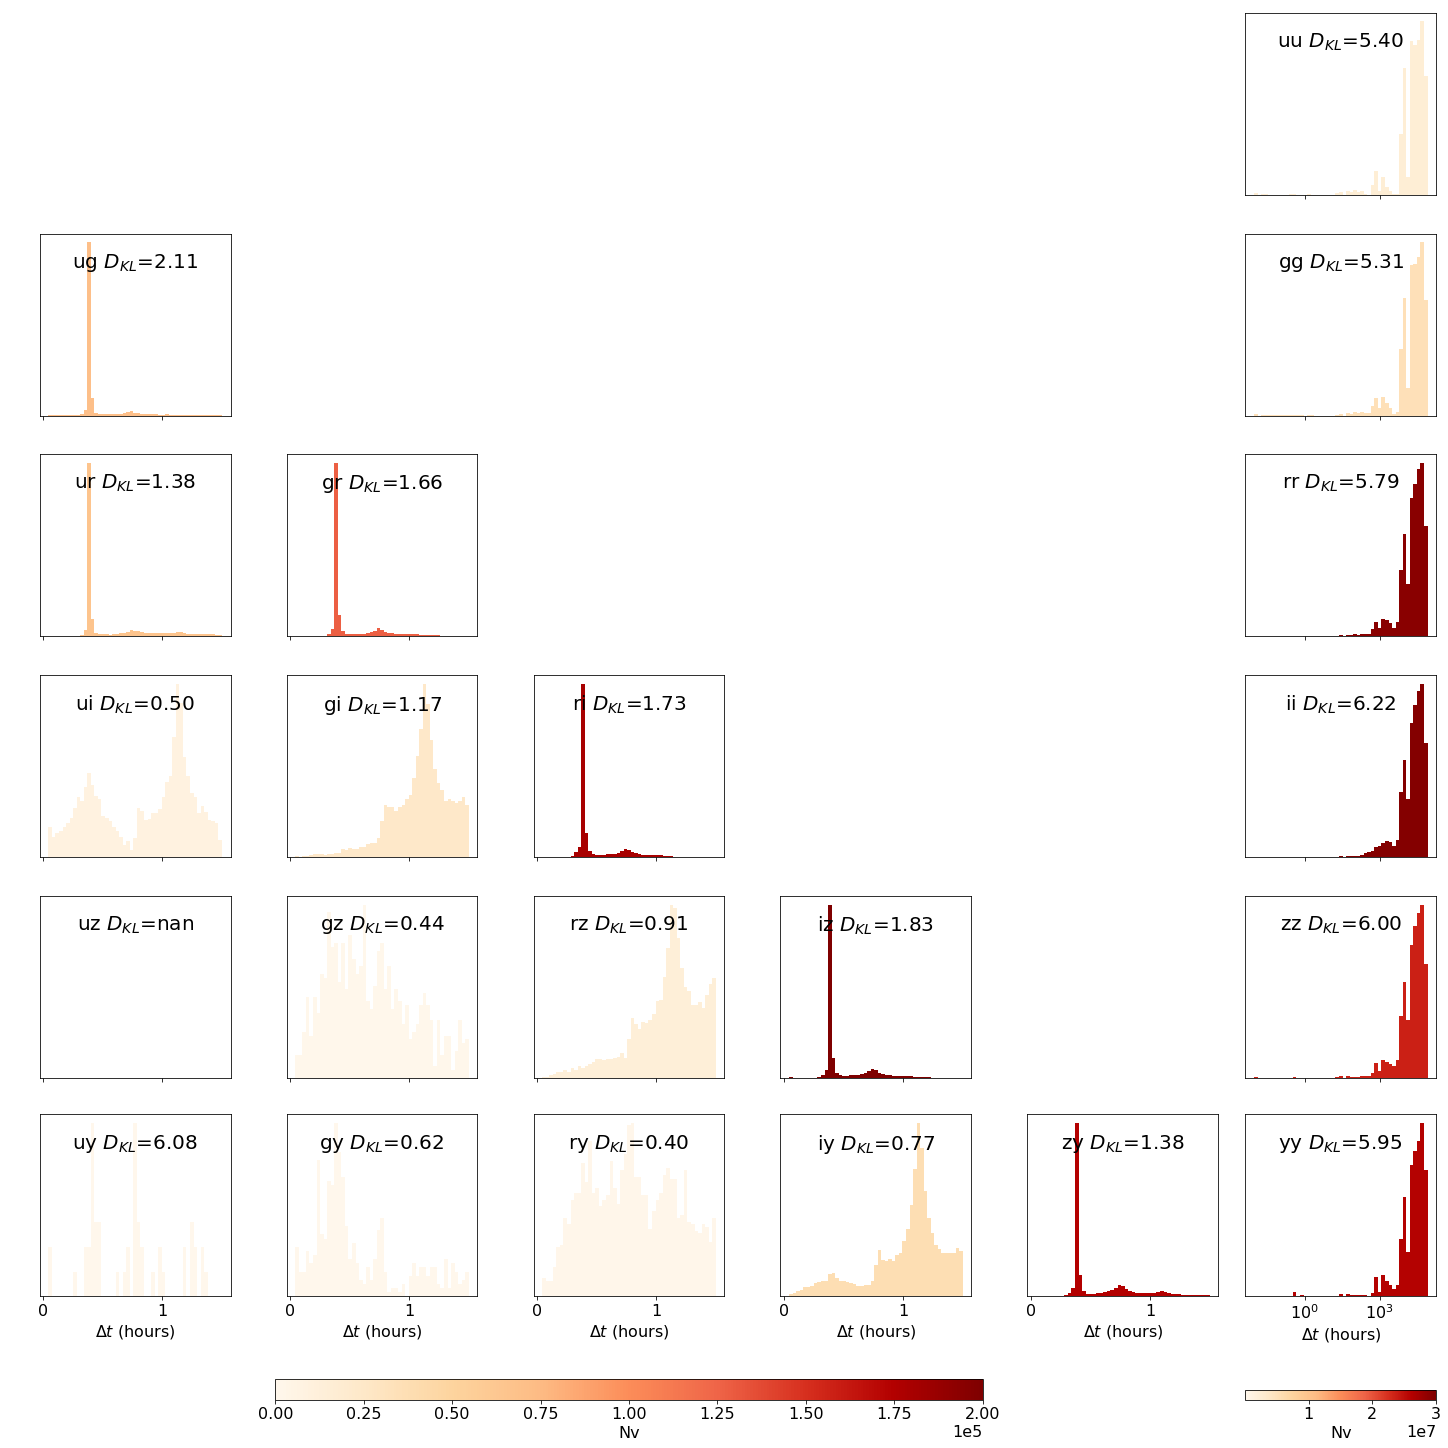

In [13]:

plot_hist_colorbar(filter_dict, figsize=(20, 20), histbins=[bins_log, bins_lin], 
                   cumulative=False, density=False, histtype='stepfilled')

